# Minfilter 5D

In [4]:
%matplotlib inline
import pandas as pd
from os import listdir
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_rows', 100)

path = 'csv'
prefix = 'minfilter_test_2048x2048'

columns = ['stat', 'rank', 'size', 'round', 'time_ms']
data = pd.DataFrame(columns=columns + ['method'])
for file in listdir(path):
    if not file.endswith('.csv') or file == 'stats.csv' or not file.startswith(prefix):
        continue
    if file.count('x') != 4:
        continue
    print(file)
    
    d = pd.read_csv(os.path.join(path, file), names=columns)
    d['method'] = file.replace('.csv', '').split('_')[-1]
    d['image_size'] = int(file.replace('.csv', '').split('_')[-2].split('x')[-1])
    
    data = pd.concat([data, d])
data.reset_index()

for t in ['rank', 'size', 'round', 'time_ms']:
    data[t] = data[t].astype('int')

# skip first run
data = data[(data['round'] == 0)] # | (data['stat'].isin(['read', 'write']))]
data['image_size'].unique()

def fix_labels(ax):
    for label in ax.legend().get_texts():
        n = int(float(label.get_text()))
        label.set_text(f"2048x2048x{n}x{n}x{n}")

minfilter_test_2048x2048x1x1x1_clij.csv
minfilter_test_2048x2048x1x1x1_default.csv
minfilter_test_2048x2048x1x1x1_mpi.csv
minfilter_test_2048x2048x1x1x1_mpisingle.csv
minfilter_test_2048x2048x1x1x1_nativempi.csv
minfilter_test_2048x2048x2x2x2_clij.csv
minfilter_test_2048x2048x2x2x2_default.csv
minfilter_test_2048x2048x2x2x2_mpi.csv
minfilter_test_2048x2048x2x2x2_mpisingle.csv
minfilter_test_2048x2048x2x2x2_nativempi.csv
minfilter_test_2048x2048x3x3x3_default.csv
minfilter_test_2048x2048x3x3x3_mpi.csv
minfilter_test_2048x2048x3x3x3_nativempi.csv


In [5]:
def by_imagesize(method, stat='total_op'):
    series = {}
    for image_size in sorted(data['image_size'].unique()):
        ds = data[(data['stat'] == stat) & (data['method'] == method) & (data['image_size'] == image_size)].pivot_table(index=['size', 'round'], columns='rank', values='time_ms')
        time = defaultdict(list)
        for idx, times in ds.iterrows():
            size, round = idx
            time[size].append(max(times))

        averaged = {k: sum(v)/len(v) for k, v in time.items()} 
        series[image_size] = pd.Series(averaged, dtype=np.float64)
    
    df = pd.DataFrame(series).dropna(axis=1,how='all')
    df.index.name = 'size'
    return df
display('default')
display(by_imagesize('default'))
display('mpi')
display(by_imagesize('mpi'))
display('nativempi')
display(by_imagesize('nativempi'))
display('mpisingle')
display(by_imagesize('mpisingle'))
display('clij')
display(by_imagesize('clij'))

'default'

,1.0,2.0
size,,
1,700.0,374442.0


'mpi'

,1.0,2.0,3.0
size,,,
1,831.0,356258.0,NaN
2,806.0,178477.0,NaN
4,993.0,93034.0,314076.0
6,1106.0,61470.0,NaN
8,1211.0,48312.0,NaN
10,1201.0,38059.0,NaN
12,1305.0,32955.0,NaN
14,1608.0,28124.0,89647.0
16,1743.0,25176.0,81351.0


'nativempi'

,1.0,2.0,3.0
size,,,
1,200.0,1445.0,16665.0
2,382.0,1104.0,8730.0
4,577.0,922.0,4897.0
6,762.0,957.0,4011.0
8,937.0,1117.0,3126.0
10,1155.0,1209.0,2937.0
12,1519.0,1437.0,3158.0
14,1450.0,1652.0,2832.0
16,1765.0,1811.0,2910.0


'mpisingle'

,1.0
size,
1,3793.0
2,2410.0
4,1647.0
6,1394.0
8,1528.0
10,1453.0
12,1440.0
14,1554.0
16,1927.0


'clij'

,1.0,2.0
size,,
1,2927.0,3229.0


In [6]:
by_imagesize('nativempi')#, stat='copyToNative')
by_imagesize('mpi', stat='gather')

,1.0,2.0,3.0
size,,,
1,12.0,26.0,NaN
2,28.0,50.0,NaN
4,59.0,75.0,111.0
6,92.0,104.0,NaN
8,117.0,148.0,NaN
10,135.0,178.0,NaN
12,160.0,199.0,NaN
14,203.0,208.0,279.0
16,240.0,243.0,287.0


1.0       700.0
2.0    374442.0
Name: 1, dtype: float64

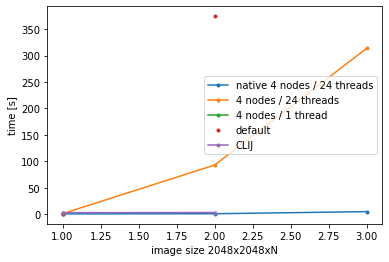

In [7]:
plt.plot(by_imagesize('nativempi').loc[4]/1000, marker='.', label='native 4 nodes / 24 threads')
plt.plot(by_imagesize('mpi').loc[4]/1000, marker='.', label='4 nodes / 24 threads')
plt.plot(by_imagesize('mpisingle').loc[4]/1000, marker='.', label='4 nodes / 1 thread')
plt.plot(by_imagesize('default').loc[1]/1000, marker='.', label='default', linestyle='')
plt.plot(by_imagesize('clij').loc[1]/1000, marker='.', label='CLIJ')
plt.xlabel('image size 2048x2048xN')
plt.ylabel('time [s]')
plt.legend()
plt.savefig('figures/minfilter5d_comparison.pdf')
by_imagesize('default').loc[1]

In [8]:
display(by_imagesize('mpi', stat='gather'))
display(by_imagesize('mpi', stat='cz.it4i.scijava.mpi.ops.parallel.Parallel'))
#display(by_imagesize('mpi', stat='barrier'))
display(by_imagesize('mpi', stat='total_op'))

,1.0,2.0,3.0
size,,,
1,12.0,26.0,NaN
2,28.0,50.0,NaN
4,59.0,75.0,111.0
6,92.0,104.0,NaN
8,117.0,148.0,NaN
10,135.0,178.0,NaN
12,160.0,199.0,NaN
14,203.0,208.0,279.0
16,240.0,243.0,287.0


,1.0,2.0,3.0
size,,,
1,626.0,356051.0,NaN
2,525.0,178182.0,NaN
4,651.0,92690.0,313709.0
6,722.0,61067.0,NaN
8,764.0,47823.0,NaN
10,721.0,37532.0,NaN
12,738.0,32355.0,NaN
14,996.0,27492.0,88941.0
16,1027.0,24405.0,80593.0


,1.0,2.0,3.0
size,,,
1,831.0,356258.0,NaN
2,806.0,178477.0,NaN
4,993.0,93034.0,314076.0
6,1106.0,61470.0,NaN
8,1211.0,48312.0,NaN
10,1201.0,38059.0,NaN
12,1305.0,32955.0,NaN
14,1608.0,28124.0,89647.0
16,1743.0,25176.0,81351.0


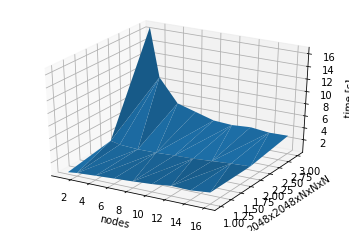

In [9]:
d = pd.DataFrame(by_imagesize('nativempi').unstack().reset_index())
d.rename(columns={'level_0':'image_size', 0: 'time_ms'}, inplace=True)

fig = plt.figure()
ax = fig.gca(projection='3d') #, title='Convolution time of image size on number of nodes/1thread')
ax.plot_trisurf(d['size'], d['image_size'], d['time_ms'] / 1000)
ax.set_xlabel('nodes')
ax.set_ylabel('2048x2048xNxNxN')
ax.set_zlabel('time [s]')
plt.savefig('figures/minfilter5d_mpisingle_3d.pdf')
plt.show()

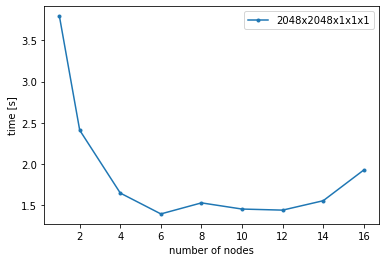

In [10]:
ax = (by_imagesize('mpisingle')/1000).plot(marker='.')#, title='Convolution time for single thread')
ax.set_ylabel('time [s]')
ax.set_xlabel('number of nodes')
fix_labels(ax)
plt.savefig('figures/minfilter_mpisingle_time.pdf')

,1.0
size,
1,3793.0
2,2410.0
4,1647.0
6,1394.0
8,1528.0
10,1453.0
12,1440.0
14,1554.0
16,1927.0


,1.0,ideal
size,,
1,1.000000,1
2,1.573859,2
4,2.302975,4
6,2.720947,6
8,2.482330,8
10,2.610461,10
12,2.634028,12
14,2.440798,14
16,1.968345,16


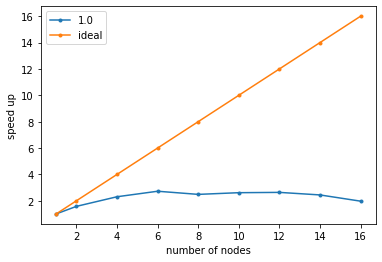

In [11]:
ds = by_imagesize('mpisingle')

display(ds)
speedup = ds.iloc[0] / ds
speedup['ideal'] = [1] + list(range(2, 17, 2))
display(speedup)
ax = speedup.plot(marker='.') #, title='convolution speedup for single thread')
ax.set_ylabel('speed up')
ax.set_xlabel('number of nodes')
plt.savefig('figures/minfilter5d_mpisingle_speedup.pdf')